In [116]:
import normflows as nf 
import torch.optim as optim


In [117]:
base = nf.distributions.base.DiagGaussian(2)

num_layers = 16
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 32, 32, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))


# If the target density is given
target = nf.distributions.target.TwoMoons()
model = nf.NormalizingFlow(base, flows, target)

# When minimizing the reverse KLD based on the given target distribution
loss = model.reverse_kld(num_samples=1024)

loss.backward()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Update the parameters
optimizer.step()

/home/admin-sbraik/Documents/InternshipProduction/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

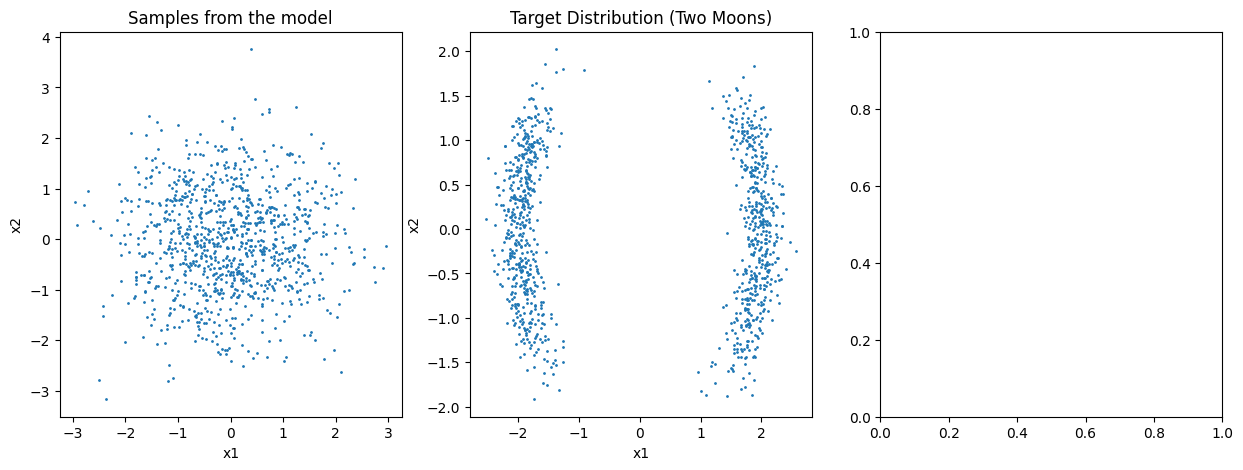

In [ ]:
import torch
import matplotlib.pyplot as plt

# Sample from the model
samples = model.sample(1000)

# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot samples from the model
plt.subplot(131)
plt.scatter(samples[0].detach().numpy()[:, 0], samples[0].detach().numpy()[:, 1], s=1)
plt.title('Samples from the model')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot target distribution (Two Moons)
plt.subplot(132)
target_samples = target.sample(1000)
plt.scatter(target_samples.detach().numpy()[:, 0], target_samples.detach().numpy()[:, 1], s=1)
plt.title('Target Distribution (Two Moons)')
plt.xlabel('x1')
plt.ylabel('x2')

# Plot model density (using grid evaluation)
plt.subplot(133)
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], 1)
log_prob = model.log_prob(zz)
plt.pcolormesh(xx.detach().numpy(), yy.detach().numpy(), torch.exp(log_prob).detach().reshape(grid_size, grid_size).numpy())